## Using MCMC to fit real data

### AY 128/256 (UC Berkeley, 2021-2024)

* Let's look at a famous dataset
<img src="hubble_diagram.jpg" width="90%">
* Hubble (1929) finds that more distant galaxies have larger positive velocities than closer galaxies
* Ends up being a big deal
* What were some of our crisiticms of this plot, and by extension the result, from our first meeing?

## Our challenge
* Hubble found $H_0 \sim 500$ km/s/Mpc, more or less fitting data with no error bars by eye.
* Let's see how well this result stands up to more detailed analysis.

## Step 1: Data Wrangling
* We need to get Hubble's data
* Fortunately, it's in Table 1 of Hubble (1929)
<img src="hubble_table.jpeg" width="80%">

 - $m_s$ = photographic magnitude of brightest stars involved.

 - $r$ = distance in units of $10^6$ parsecs. The first two are Shapley’s values.

 - $v$ = measured velocities in km/s.    NGC 6822, 221, 224 and 5457 are recent determinations by Humason.

 - $m_t$ = Holetschek’s visual magnitude as corrected by Hopmann. The first three objects were not measured by Holetschek, and the values of mt represent estimates by the author based upon such data as are available.

 - $M_t$ = total visual absolute magnitude computed from m_t and $r$.

* Since it's a short table, I turned this into a csv file by hand.  It contains galaxy name, distance, velocity, and absolute magnitude.

## Step 1: Data Visualization
* Let's use Pandas to read in the data and try to re-create Hubble's plot

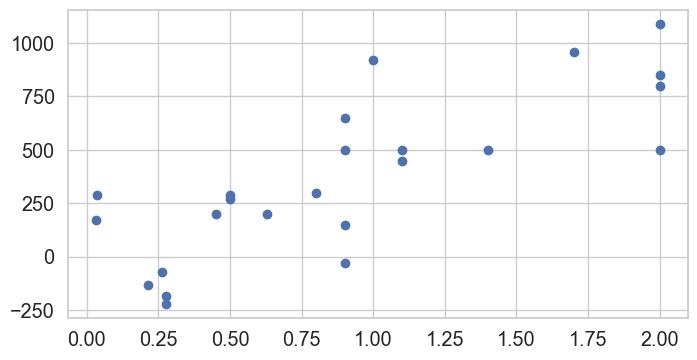

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]

# read in the csv file; column names are in the file already
df = pd.read_csv('hubble1929.tab1')

import pylab as plt
# plot distance and velocity
plt.scatter(df['distance'], df['velocity'])

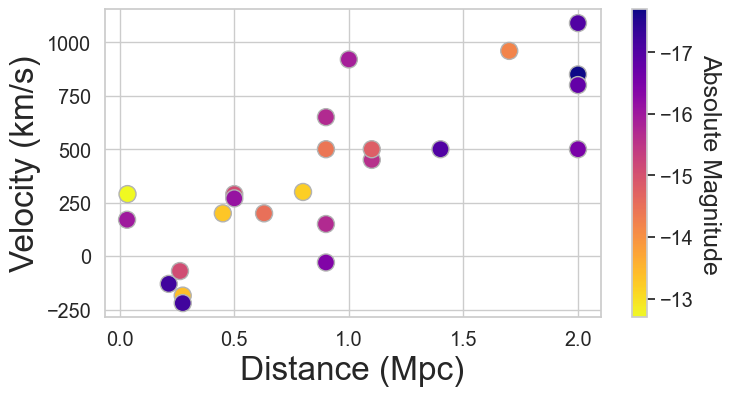

In [5]:
# Let's make this plot look a bit nicer using Seaborn
import seaborn as sns
sns.set(style="whitegrid", color_codes=True, font_scale=1.3)

cmap = plt.get_cmap('plasma')

plt.scatter(df['distance'], df['velocity'], c=df['absMag'], s=150, edgecolor='0.7', cmap=cmap)
plt.xlabel('Distance (Mpc)', size=24)
plt.ylabel('Velocity (km/s)', size=24)

cb = plt.colorbar()
cb.set_label("Absolute Magnitude", rotation=270, labelpad=20, fontsize=18)

# make colorbar brighest to faintest
cb.ax.invert_yaxis()


## Step 3a: Write down a model for the data
* $y_n = m~x_n + b$
 - Linear model to descibe velocity as a function of distance
 - 2 parameters to fit for: $m$ (slope) and $b$ (offset)
 - $y_n$: velocity of the nth galaxy; $x_n$: distance to the nth galaxy
 - We have no error bars (i.e., no $\sigma_n$) -- is this a problem? Why or why not?

## Step 3b: Error bars
* Let's fit for the scatter in the data (or the size of the typical uncertainty)
* Assume errors are normally distributed
* error term: $logsig = \log(\sigma)$
* why use $\log(\sigma)$ instead of $\sigma$ as a parameter?

## Aside: Review Bayes's theorem
* Bayes's theorem: $P(\theta \mid \{y_n\}) \propto P(\{y_n\} \mid \theta) \, P(\theta)$
 - $\theta = \{m,b,\log(\sigma)\}$
* Assume we have $N$ independent data points (i.e., galaxies in this case).  The posterior for the entire dataset is the product of the posteriors for each data point.

 - $P(\theta \mid \{y_n\}) = \prod_n^N P(\theta \mid y_n) \propto\ \prod_n^N P( y_n \mid \theta)\, P(\theta)$ 
 

* Or in log-space:
 - $\log P(\theta \mid \{y_n\}) \propto \sum_n^N \log P(y_n \mid \theta) + \log P(\theta)$
 - why work in log-space?

## Step 4: Write down priors and log-likelihood

* Uniform prior on $m$:

 $$
P(m)=
\begin{cases}
1 \, \rm{if} \, 100 < m < 1000\\
0 \, {\rm otherwise}\\
\end{cases}
$$

* Uniform prior on $b$:

 $$
P(b)=
\begin{cases}
1 \, \rm{if} -500 < b < 500\\
0 \, {\rm otherwise}\\
\end{cases}
$$

* Uniform prior on $\log(\sigma)$:

 $$
P(b)=
\begin{cases}
1 \, \rm{if} -10 < \log(\sigma) < 10\\
0 \, {\rm otherwise}\\
\end{cases}
$$
 

* Likelihood function for a normal distribution:

\begin{equation}
P(\{y_n\} \mid \{m, b, \log(\sigma)\}) = \frac{1}{\sqrt{2\pi\sigma}} e^{-\frac{(y_n - mx_n - b)^2}{2 \sigma_n^2}}
\end{equation}

 - where $x_n$ is shorthand for the 'distance' variable


* log-Likelihood function for a normal distribution:

 $ \log P(\{y_n\} \mid \{m, b, \log(\sigma)\} = -\frac{1}{2} \sum^{N}_{n=1} \Big(\frac{(y_n - mx_n - b)^2}{\sigma_n^2} + \log(2 \pi \sigma_n^2) \Big)$
 
   - how might this change if we had values for $\sigma_n$ already?

Another way of writing this model:
* $m \sim {\rm Uniform}(100, 1000)$
* $b \sim {\rm Uniform}(-500, 500)$
* $\log(\sigma) \sim {\rm Uniform}(-10,10)$
* $y_n \sim {\rm Normal}(m x_n +b, \sigma)$

## Steps 5 & 6: Implement and run the model in python using PyMC, make some diagnostic plots




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, b, logsig]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


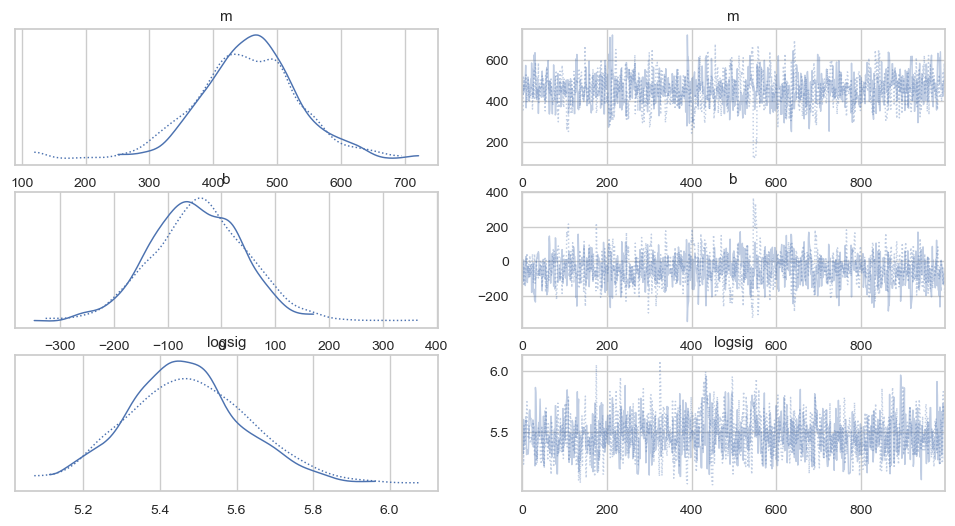

In [6]:
import pymc as pm
import arviz as az
from arviz import plot_trace as traceplot

# set up the model
with pm.Model() as model:
    
    # define priors
    m = pm.Uniform("m", lower=100, upper=1000)
    b = pm.Uniform("b", lower=-500, upper=500)
    logsig = pm.Uniform("logsig", lower=-10, upper=10)
    
    # define the log-likelihood function
    pm.Normal("obs", mu = m*df['distance'].values+b, 
              sigma=np.exp(logsig), observed=df['velocity'].values)

    # now set up the model to run
    # default of PyMC is to use the no-turn sampler (NUTS)
    
    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2, discard_tuned_samples=True)
    
    # traceplot is a routine for plotting the 'traces' from the samples
    _ = traceplot(trace, var_names=["m", "b", "logsig"])


In [4]:
# pm.summary provides some useful summary and convergance statistics
az.summary(trace, var_names=["m", "b", "logsig"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,453.392,79.903,301.675,600.194,2.688,1.901,912.0,848.0,1.00
b,-38.212,86.099,-205.206,114.594,2.800,2.180,966.0,891.0,1.00
logsig,5.474,0.150,5.200,5.763,0.004,0.003,1184.0,1130.0,1.01


`corner` is a nice routine for visualizing the marginalized posterior distributions

  - 1d plots (1d histograms) are called **marginalized distributions**
  - 2d plots (2d histograms) are called **joint distributions**


The typical error in velocity is ~236 km/s


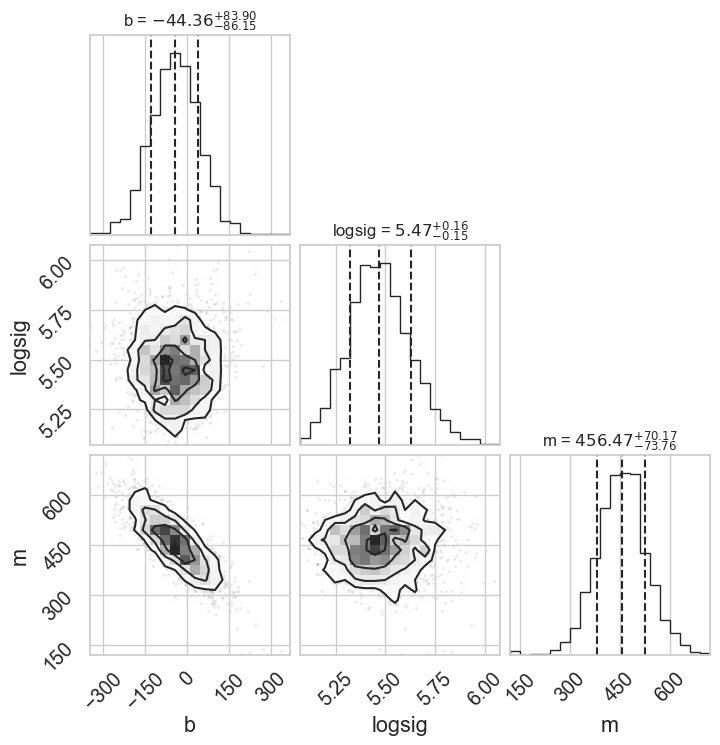

In [8]:
import corner

# make the corner plot and plot results from Hubble's paper as 'truth'
# overplot percentiles: 16, 50, 84 on 1d historgrams
_ = corner.corner(trace, truths=[500, 0, None], quantiles=[.16, .50, .84], show_titles=True,
    title_kwargs={"fontsize": 12})

# how big is the scatter/typical error in the data?
# let's use the median of logsig for this
print(f"The typical error in velocity is ~{int(np.median(np.exp(trace.posterior['logsig'])))} km/s")

## Step 7: Posterior Predictive check
* the technical term that means to plot your model on top of the data and do a sanity check

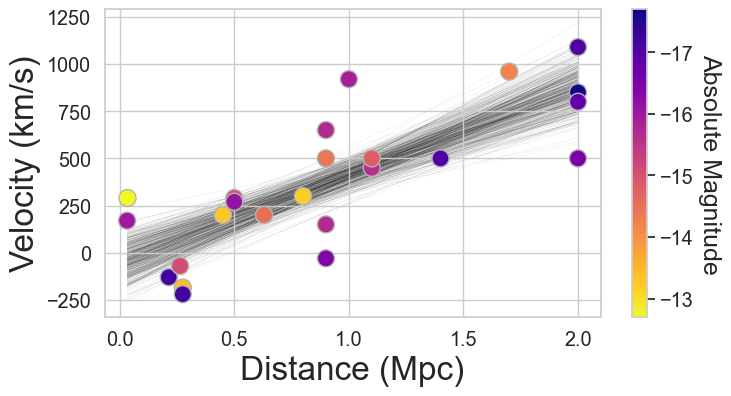

In [9]:
# Let's make this plot look a bit nicer using Seaborn

#import seaborn as sns
sns.set(style="whitegrid", color_codes=True, font_scale=1.3)
plt.scatter(df['distance'], df['velocity'], c=df['absMag'], s=150, edgecolor='0.7', cmap=cmap)
plt.xlabel('Distance (Mpc)', size=24)
plt.ylabel('Velocity (km/s)', size=24)
cb = plt.colorbar()
cb.set_label("Absolute Magnitude", rotation=270, labelpad=20, fontsize=18)
cb.ax.invert_yaxis()
np.random.seed(42)


# this code loops over the trace array and pulls 500 random sets of m,b, and logsig
# it then generates 500 posterior models (i.e., lines in velocity and distance space) and overplots them on the data


m_model = trace.posterior['m'].values.flatten()
b_model = trace.posterior['b'].values.flatten()
dist = np.asarray(df['distance'])


for i in np.random.randint(0, len(m_model)-1, 500):
    plt.plot(dist, m_model[i]*dist + b_model[i], color="k", lw=0.1, alpha=0.3, zorder=0)

